## Gamelan tuning similarity pipeline


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import helpers
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [3]:
# Load and play audio file
audio_file_path = "audios/tj1.wav"
y, sr = librosa.load(audio_file_path, duration=30)
print("Input audio:")
display(ipd.Audio(y, rate=sr))

Input audio:


/tmp/ipykernel_206470/3821860033.py:7: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), y_axis="log")


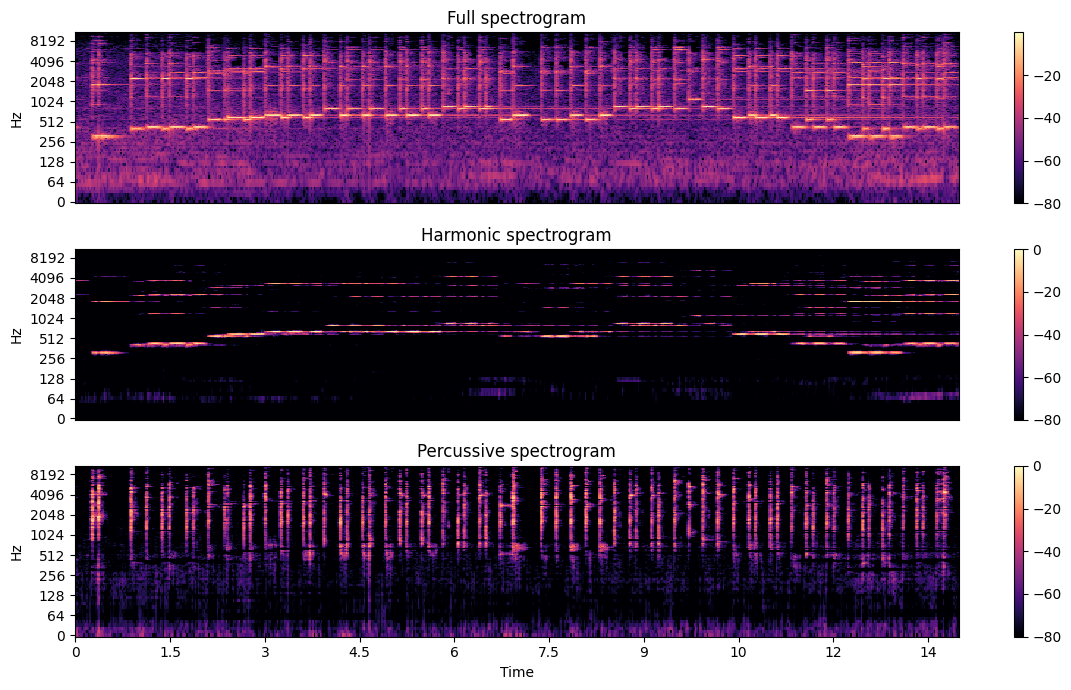

In [18]:
# compute stft and harmonic percussive separation
spectrogram = librosa.stft(y)
harmonic, percussive = librosa.decompose.hpss(spectrogram, margin=16, kernel_size=31)
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), y_axis="log")
plt.colorbar()
plt.title("Full spectrogram")

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(harmonic), ref=np.max), y_axis="log")
plt.colorbar()
plt.title("Harmonic spectrogram")

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(percussive), ref=np.max), y_axis="log", x_axis="time")
plt.colorbar()
plt.title("Percussive spectrogram")
plt.tight_layout()

plt.show()

Text(0.5, 1.0, 'DSP: Parabolic interpolation Frequency')

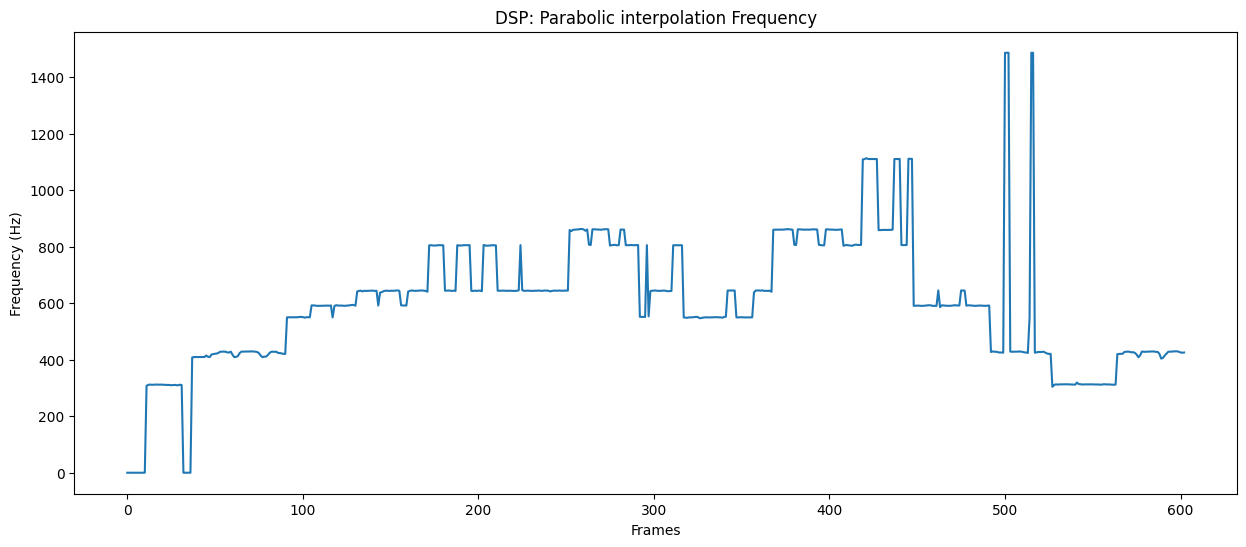

In [5]:
# Detect fundamental frequency and plot pitch countour
pitches_dsp = helpers.detect_pitch(S=harmonic, sr=sr, fmin=120, fmax=2000)

fig, ax = plt.subplots(figsize=(15, 6))
frames = np.arange(len(pitches_dsp))

ax.plot(frames, pitches_dsp)
ax.set_xlabel("Frames")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("DSP: Parabolic interpolation Frequency")


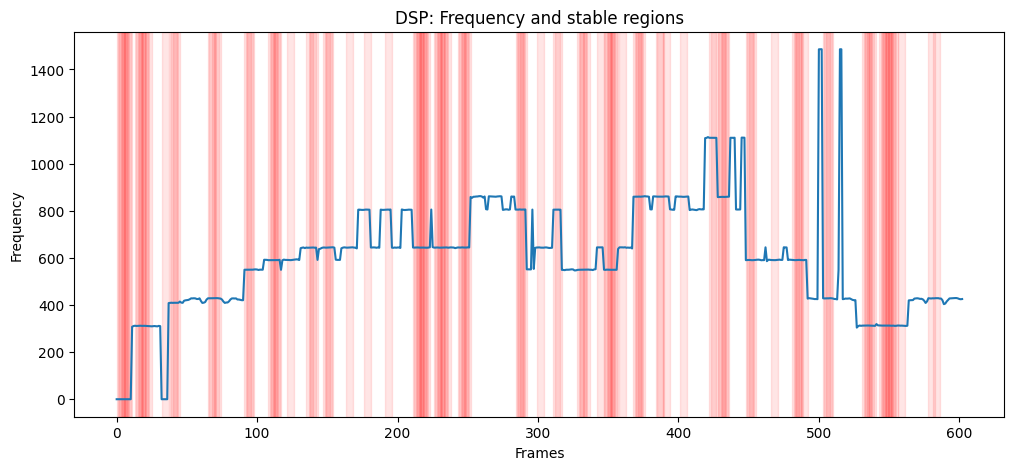

In [10]:
stable_regions, segments = helpers.find_stable_regions(frequencies=pitches_dsp, window_size=5, threshold=0.4)
fig, ax = plt.subplots(figsize=(12,5))

# Plot the stable regions of pitch contour
ax.plot(frames, pitches_dsp)
ax.set_xlabel("Frames")
ax.set_ylabel("Frequency")
ax.set_title("DSP: Frequency and stable regions")

for start, end in stable_regions:
    plt.axvspan(start, end, color='red', alpha=0.1)

plt.show()

In [11]:
# Group together dectected frequencies that are close to each other less than 10hz
tone_group = helpers.group_and_average_frequencies(segments)

# Sanity check, play estimated tones
wait_time = 0.5
audio = np.array([])
for tone in tone_group:
    tone_audio = librosa.tone(tone, duration=1)
    wait_audio = np.zeros(int(wait_time * sr))
    audio = np.concatenate((audio, tone_audio, wait_audio))

print("Playing concatenated audio:")
display(ipd.Audio(audio, rate=sr))

Playing concatenated audio:


In [17]:
# Given the extracted and grouped tones, it finds the scale.
# It returns the interval in cents bewtween low-ding to hi-ding.
scale_distances = helpers.find_scale(tone_group)

Ding: 549.7723106971154
Dong: 590.9153401692708
Deng: 643.9486653645833
Dung: 805.0412445068359
Dang: 859.7108306884766
Hi-ding: 1109.9400024414062
Scale distances: [124.94 148.79 386.54 113.75 442.27]


/home/stef/uni/mir/gamelan-project/mir-gamelan/helpers.py:104: RuntimeWarning: divide by zero encountered in scalar divide
  distance_in_cents = 1200 * np.log2(tone_b / tone_a)


In [16]:
begbeg = np.array([120, 114, 432, 81, 453])
sedang = np.array([136, 155, 379, 134, 396])
tirus = np.array([197, 180, 347, 104, 372])

similarity = cosine_similarity([scale_distances], [begbeg, sedang, tirus])[0]
max_similarity = np.max(similarity)
print(f"Cosine similarity to begbeg: {similarity[0]}{' *winner*' if similarity[0] == max_similarity else ''}")
print(f"Cosine similarity to sedang: {similarity[1]}{' *winner*' if similarity[1] == max_similarity else ''}")
print(f"Cosine similarity to tirus: {similarity[2]}{' *winner*' if similarity[2] == max_similarity else ''}")
print("-------")

eucl_distances = euclidean_distances(X=[scale_distances], Y=[begbeg, sedang, tirus])[0]
min_distance = np.min(eucl_distances)
print(f"Euclidian distance to begbeg: {eucl_distances[0]}{' *winner*' if eucl_distances[0] == min_distance else ''}")
print(f"Euclidian distance to sedang: {eucl_distances[1]}{' *winner*' if eucl_distances[1] == min_distance else ''}")
print(f"Euclidian distance to tirus: {eucl_distances[2]}{' *winner*' if eucl_distances[2] == min_distance else ''}")
print("-------")

gaussian_results = {
    'begbeg': helpers.gaussian_kernel(scale_distances, begbeg),
    'sedang': helpers.gaussian_kernel(scale_distances, sedang),
    'tirus': helpers.gaussian_kernel(scale_distances, tirus)
}
max_similarity = max(gaussian_results.values())
for key, value in gaussian_results.items():
    print(f"Gaussian similarity to {key}: {value}{' *winner*' if value == max_similarity else ''}")

Cosine similarity to begbeg: 0.9952031685938864
Cosine similarity to sedang: 0.9973943903764346 *winner*
Cosine similarity to tirus: 0.9854110746183501
-------
Euclidian distance to begbeg: 67.0004082077124
Euclidian distance to sedang: 52.618577517831206 *winner*
Euclidian distance to tirus: 112.97369029999851
-------
Gaussian similarity to begbeg: 0.7989533383370496
Gaussian similarity to sedang: 0.870719206240913 *winner*
Gaussian similarity to tirus: 0.5282673731001414
